In [1]:
import numpy as np

## Softmax

Обобщение логистической функции для многомерного случая. Функция преобразует вектор $z$ размерности $K$ в вектор $\sigma$ той же размерности, где каждая координата $\sigma_i$ полученного вектора представлена вещественным числом в интервале $[0,1]$ и сумма координат равна 1.

Координаты $\sigma_i$ вычисляются следующим образом:


${\displaystyle \sigma (z)_{i}={\frac {e^{z_{i}}}{\displaystyle \sum _{k\mathop {=} 1}^{K}e^{z_{k}}}}}$

1. Реализуйте функцию softmax, которая на вход принимает вектор $z$, а на выходе считает от него софтмакс.
2. Добавьте возможность принимать на вход матрицу и считать softmax по столбцам (батч)

In [2]:
# 1
def softmax(z):
    z = np.array(z)
    denominator = np.exp(z).sum()
    smz = np.exp(z) / denominator
    return smz

In [3]:
z = np.array([1,2,3])
softmax(z)

array([ 0.09003057,  0.24472847,  0.66524096])

In [4]:
softmax(z).sum()

1.0

In [5]:
# 2
def softmax_col(z):
    z = np.array(z)
    denominator = np.exp(z).sum(axis = 0)
    smz = (np.exp(z) / denominator)
    return smz

In [6]:
z = np.array([[1,2,3],
              [1,1,1],
              [9,9,9],
              [8,7,6]])
softmax_col(z)

array([[  2.45122603e-04,   8.02301516e-04,   2.35488234e-03],
       [  2.45122603e-04,   2.95150233e-04,   3.18698669e-04],
       [  7.30700181e-01,   8.79830446e-01,   9.50027343e-01],
       [  2.68809574e-01,   1.19072103e-01,   4.72990763e-02]])

In [7]:
softmax_col(z).sum(axis=0)

array([ 1.,  1.,  1.])

## Дивергенция Кульбака-Лейблера

* Показать что $D_{KL}(p||q) \ge 0$ для любых $p$ и $q$. Для этого можно воспользоваться [формулой Йенсена](https://en.wikipedia.org/wiki/Jensen%27s_inequality "неравенство Йенсена")
* ~~Показать, что максимизация правдопобия эквивалентна минимизации $D_{KL}$~~. 

<img src='firstn.jpg'>

## GLM

На слайде 27 в лекциях показывается, что распределение Бернулли входит в экспоненциальное семейство. Чему равно $\phi$?

<img src='secondn.jpg'>

## Обучение линейных моделей

Буквально три-четыре года назад для того, чтобы обучить нейронную сеть было необходимо вручную вычислить градиент функции потерь. Затем, обычно, правильность решения проверялась численно. После появления фреймворков вроде Theano и TF это стало необязательным, благодаря чему исследователи и инженеры могут проводить свои эксперименты значительно быстрее. В данной работе мы посчитаем и проверим градиенты для линейных моделей, рассмотренных на первой лекции; а так же в явном виде реализуем алгоритм оптимизации.      

In [2]:
import numpy as np
from keras.datasets import cifar10
from random import randrange
import time

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000. 

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
x_train.shape

(50000, 32, 32, 3)

Визуализируем классы

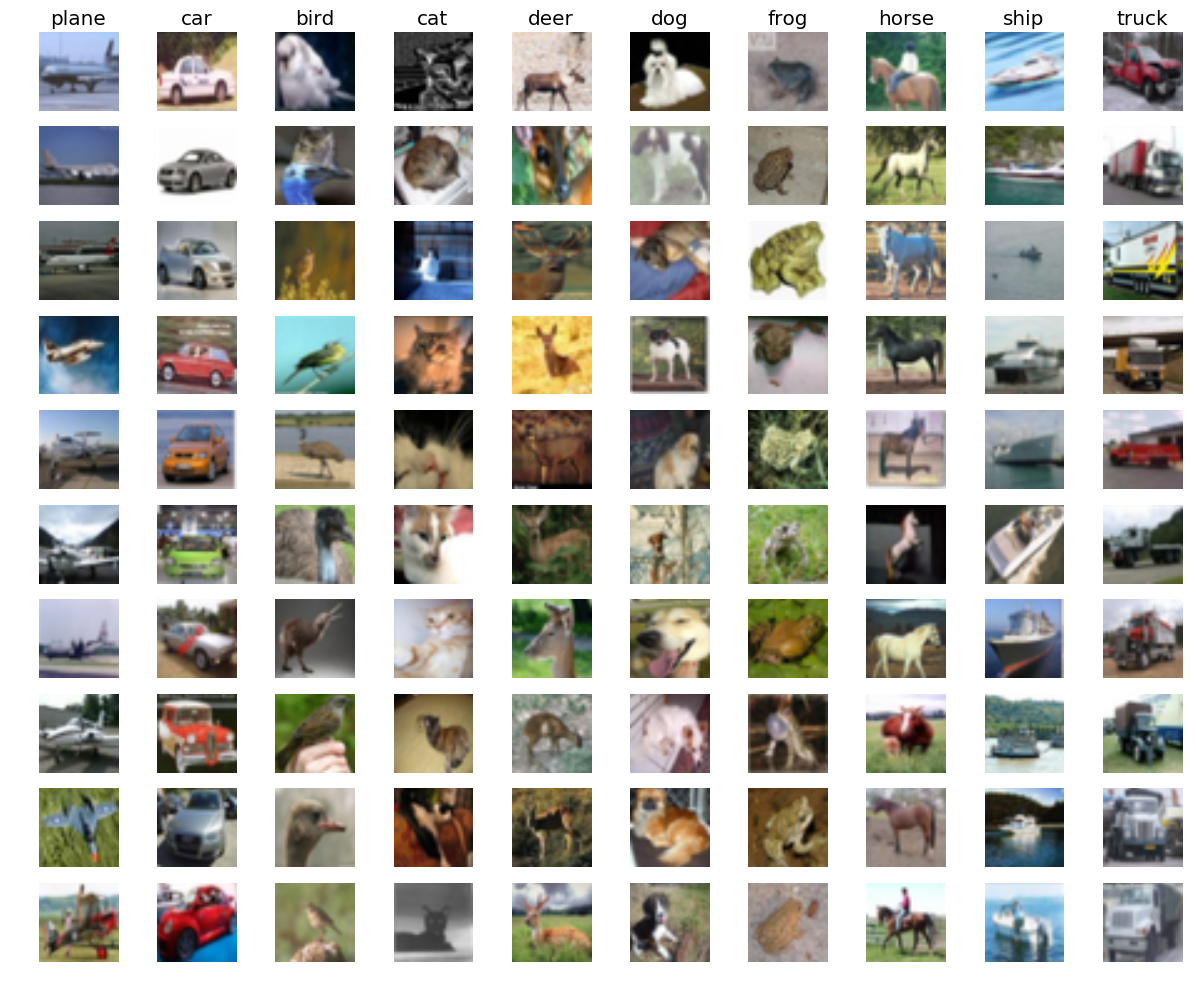

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
# Preprocessing: преобразуем изображения к плоскому виду
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

# Печатаем размерности, чтобы проверить что мы не ошиблись
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


[ 130.71074  136.05614  132.5538   130.14036  135.44238  131.85358
  131.05044  136.24616  132.58144  131.56886]


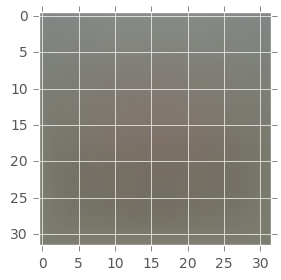

In [8]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10]) # для проверки напечаем несколько элементов
plt.figure(figsize=(3,3))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

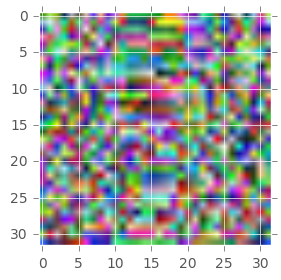

In [9]:
plt.figure(figsize=(3,3))
plt.imshow(mean_image.reshape((32,32,3))) # визуализируем полученное среднее
plt.show()

In [10]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [11]:
print(x_train.shape)

(50000, 3072)


In [12]:
# 3: Добавляем новую компоненту отвечающую за сдвиг (bias trick)
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

In [13]:
print(x_train.shape)

(50000, 3073)


**Задача 1:** Далее следует функция svm_loss, которую вам предстоит дописать.

In [14]:
def svm_loss(W, X, y, reg):
    """
    SVM loss function
    Inputs:
    - W: Матрица весов
    - X: Данные
    - y: Целевой признак
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    y = y.flatten()
    W = W.T.copy()
    
    loss = 0
    dW = np.zeros(W.shape)
    num_train = X.shape[0]

    scores = X.dot(W)
    yi_scores = scores[np.arange(scores.shape[0]),y] # http://stackoverflow.com/a/23435843/459241 
    margins = np.maximum(0, scores - np.matrix(yi_scores).T + 1)
    margins[np.arange(num_train),y] = 0
    loss = np.mean(np.sum(margins, axis=1))
    
    loss += 0.5 * reg * np.sum(np.array(W) * np.array(W))
    
    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################
    
    binary = margins
    binary[margins > 0] = 1
    row_sum = np.sum(binary, axis=1)
    binary[np.arange(num_train), y] = -row_sum.T
    dW = np.dot(X.T, binary)

    # Average
    dW /= num_train

    # Regularize
    dW += reg*W

    return loss, dW.T

In [15]:
# Заполняем матрицу весов W случайным образом
W = np.random.randn(10, 3073) * 0.0001

In [16]:
loss, grad = svm_loss(W, x_test, y_test, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.887623


In [17]:
#При помощи этой функции можно проверить градиент численно 
def grad_check_sparse(f, x, analytic_grad, num_checks):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """
    h = 1e-5

    x.shape
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        x[ix] += h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] -= 2 * h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] += h # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [18]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = svm_loss(W, x_test, y_test, 0.0)

# Проверяем численно
f = lambda w: svm_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Проверяем численно, используя регуляризацию.
# Вы ведь не забыли реализовать регуляризацию, правда? 
loss, grad = svm_loss(W, x_test, y_test, 5e1)
f = lambda w: svm_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 39.509704 analytic: 39.510707, relative error: 1.269752e-05
numerical: 27.132318 analytic: 27.136789, relative error: 8.238528e-05
numerical: 18.885762 analytic: 18.881896, relative error: 1.023811e-04
numerical: -27.315267 analytic: -27.316984, relative error: 3.142280e-05
numerical: 12.065182 analytic: 12.065769, relative error: 2.433116e-05
numerical: 7.474142 analytic: 7.473674, relative error: 3.127269e-05
numerical: -1.193642 analytic: -1.193788, relative error: 6.121324e-05
numerical: 1.732826 analytic: 1.732826, relative error: 6.637402e-12
numerical: -2.227657 analytic: -2.227543, relative error: 2.560911e-05
numerical: -2.059222 analytic: -2.067226, relative error: 1.939704e-03
numerical: -0.198529 analytic: -0.197733, relative error: 2.010535e-03
numerical: 4.054772 analytic: 4.060196, relative error: 6.683600e-04
numerical: -1.221135 analytic: -1.221431, relative error: 1.212423e-04
numerical: 21.841766 analytic: 21.837783, relative error: 9.116849e-05
numerical:

**Задача 2:** Реализуйте методы класса SVM. Для тренировки используйте градиентный спуск.

In [19]:
class SVM():
    def __init__(self):
        self.W = np.random.randn(10, 3073) * 0.0001 
        
    def train(self, x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1000, verbose=True):
        loss_history = []
        for it in range(num_iters):
            Loss, dL = svm_loss(self.W, x_train, y_train, reg)
            self.W = (self.W - learning_rate*dL)
            loss_history.append(Loss)
            
            if verbose:
                print(it, Loss)

        return loss_history
    
    def predict(self, X):
        pred = X.dot(self.W.T)
        return np.argmax(np.array(pred), axis=1).reshape(pred.shape[0],1)

Проверяем полученную реализацию.

In [20]:
tic = time.time()
svm = SVM()
loss_hist = svm.train(x_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

0 12.7910359189
1 12.0658016374
2 11.5575488995
3 11.1933954046
4 10.928808468
5 10.7254816586
6 10.5588221362
7 10.4168525665
8 10.2928527693
9 10.1825754871
10 10.083183547
11 9.99238212912
12 9.90859182985
13 9.83092744947
14 9.75836056988
15 9.69025420732
16 9.6261452257
17 9.56560980144
18 9.5081233832
19 9.45334107142
20 9.40099546311
21 9.35094339862
22 9.30289598245
23 9.25665481701
24 9.21208267188
25 9.1690488095
26 9.12739794946
27 9.08708686515
28 9.04805141535
29 9.0101802235
30 8.97338898293
31 8.93755398503
32 8.90262487465
33 8.86856873082
34 8.83534249221
35 8.8028932616
36 8.77118704102
37 8.74019473634
38 8.7098910624
39 8.68026836427
40 8.65123703145
41 8.62276728256
42 8.59483314526
43 8.56741504173
44 8.54048794828
45 8.51404777815
46 8.48806169452
47 8.46249597616
48 8.43734442949
49 8.41260380302
50 8.38825130899
51 8.36426549231
52 8.3406365519
53 8.31736164218
54 8.2944194434
55 8.27181461859
56 8.24952307259
57 8.22752637484
58 8.20582576927
59 8.1843982949
6

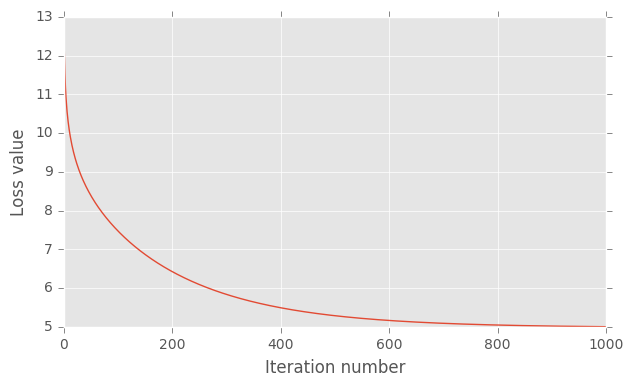

In [21]:
# Хорошая идея для отладки -- нарисовать график отношения функци потерь к номеру итерации
plt.figure(figsize=(7,4))
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [22]:
# Теперь вычислим точность на тренировочном и тестовом множествах
y_train_pred = svm.predict(x_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(x_test)
print('validation accuracy: %f' % (np.mean(y_test == y_val_pred), ))

training accuracy: 0.386140
validation accuracy: 0.381800


In [23]:
plot_weights(svm)

NameError: name 'plot_weights' is not defined

In [ ]:
def plot_weights(best_svm):
    w = best_svm.W[:,:-1] # strip out the bias
    w = w.reshape(10, 32, 32, 3)
    w_min, w_max = np.min(w), np.max(w)
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    for i in range(10):
        plt.subplot(2, 5, i + 1)

        # Rescale the weights to be between 0 and 255
        wimg = 255.0 * (w[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
        plt.imshow(wimg.astype('uint8'))
        plt.axis('off')
        plt.title(classes[i])

**Задача 3:** Подберите при помощи поиска по сетке наулучшие параметры learning rate и regularization coefficient. Для полученной модели вызовите функцию plot_weights(best_svm). Впишите свой код под этой ячейкой.

**Задача 4:** О чём говорят полученные изображения? Какие выводы мы можем сделать? Впишите ответ в поле ниже

**Задача 5:** Повторим упражнение для cross entropy loss

In [ ]:
def crossentropy_loss(W, X, y, reg):
    """
    Cross entropy loss function
   Inputs:
    - W: Матрица весов
    - X: Данные
    - y: Целевой признак
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    
    # Впишите свой код на место заглушки
    loss = 0
    dW = np.zeros(W.shape)

    return loss, dW

In [ ]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = crossentropy_loss(W, x_test, y_test, 0.0)

In [ ]:
# Грубая проверка, значения должны быть близки к -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

**Задача 6:** Кстати, почему такая проверка справедлива? Объясните

In [ ]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = crossentropy_loss(W, x_test, y_test, 0.0)


f = lambda w: crossentropy_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)


loss, grad = crossentropy_loss(W, x_test, y_test, 5e1)
f = lambda w: crossentropy_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)